In [1]:
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import csv
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")

In [31]:
import warnings
warnings.filterwarnings("ignore")

# Data Import

In [2]:
path = r"data\train.csv"
df = pd.read_csv(path, encoding = "ISO-8859-1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Apply pre-processing as indicated in Exploratory_Data_Analysis notebook.

In [3]:
df["Postal Code"] = df["Postal Code"].fillna(5401)
df["Order Date"] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df["Ship Date"] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')
df_changed = df.drop(columns=["Row ID", "Country"])


# Time Series Analysis
Okay. So now let's finally analyse the time series data further. Let's see if there are any time related patterns in the data where we could learn something from!

In [4]:
df_datetime = df_changed.set_index("Order Date")
df_datetime.head()

,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,
2017-11-08,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2017-11-08,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2017-06-12,CA-2017-138688,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
2016-10-11,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
2016-10-11,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


As a first step, the sales are plotted against the Order Date. This should help to gain some insights whether the sales are having some seasonal components or not.

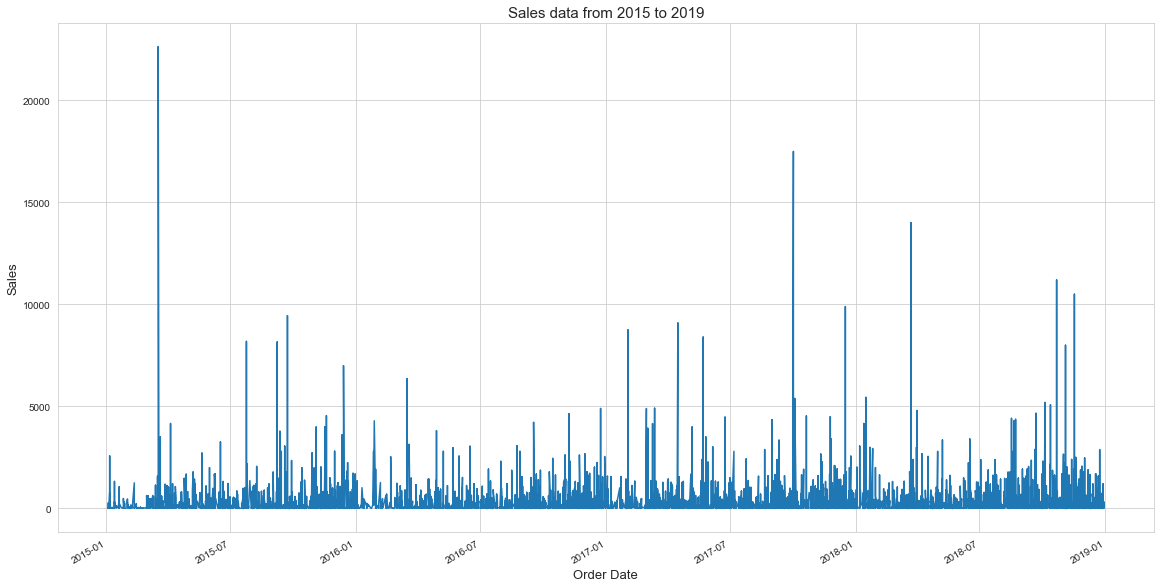

In [5]:
plt.figure(figsize=(16, 8))
df_datetime["Sales"].plot()
plt.tight_layout()
plt.title("Sales data from 2015 to 2019", size=15)
plt.ylabel("Sales", size=13)
plt.xlabel("Order Date", size=13)
plt.savefig(r"figures\sales_full_time.pdf")
plt.show()

Let's check the frequency of our data. We want to have daily sales data and only one value per day!

In [6]:
print('\nUnique dates in our data: ', len(df_datetime.index.unique()), 'Days')
our_date_range = df_datetime.index.max() - df_datetime.index.min()

# Calculate number of days in date range
print('Total days in our date range:', our_date_range.days, 'Days')


Unique dates in our data:  1230 Days
Total days in our date range: 1457 Days


In [7]:
# create daily data and replace NaN values, caused by missing days, with the linear interpolation of the days around
daily_sales = pd.DataFrame(df_datetime["Sales"].resample('D').mean()).interpolate(method='linear')
daily_sales.head(10)

,Sales
Order Date,
2015-01-03,16.448000
2015-01-04,96.020000
2015-01-05,19.536000
2015-01-06,489.677778
2015-01-07,43.579000
2015-01-08,31.925500
2015-01-09,20.272000
2015-01-10,27.415000
2015-01-11,9.940000


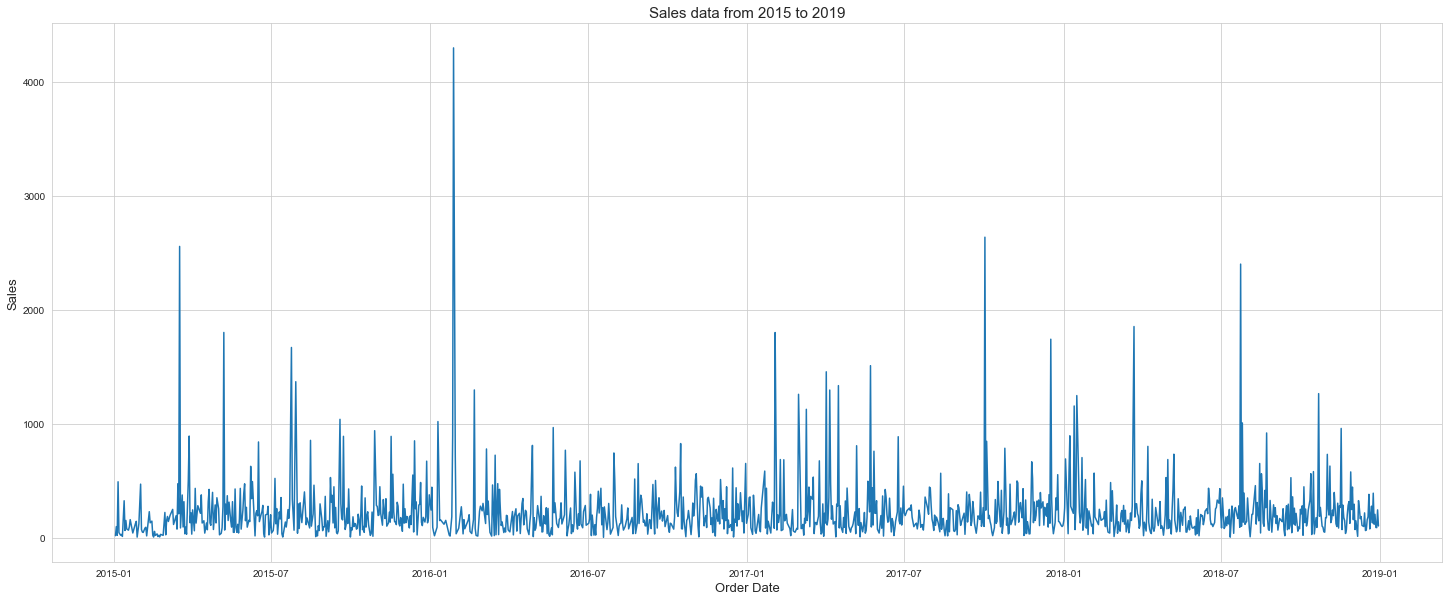

In [8]:
fig = plt.figure(figsize=(20, 8))
plt.plot(daily_sales.index, daily_sales["Sales"])
plt.tight_layout()
plt.title("Sales data from 2015 to 2019", size=15)
plt.ylabel("Sales", size=13)
plt.xlabel("Order Date", size=13)
plt.savefig(r"figures\daily_sales_full_time.pdf")
plt.show()

Looks way better now. Let's reduce the timeframe to only display the yearly sales data.

<ipython-input-9-b38e2654ad0c>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
<ipython-input-9-b38e2654ad0c>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
<ipython-input-9-b38e2654ad0c>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
<ipython-input-9-b38e2654ad0c>:5: FutureWarning: Indexing a DataFra

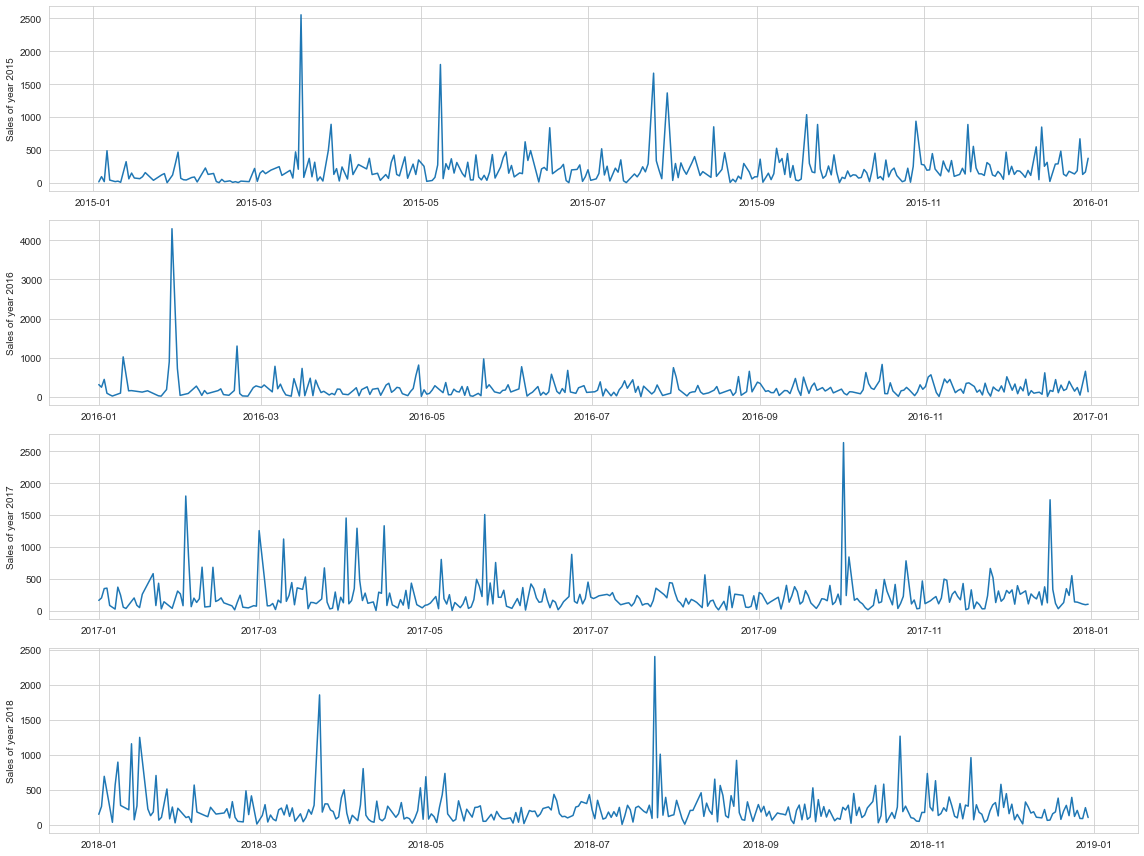

In [9]:
fig = plt.figure(figsize = (16, 12))
years = ["2015", "2016", "2017", "2018"]
for idx, year in enumerate(years):
    plt.subplot(len(years), 1, idx+1)
    plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
    plt.ylabel(f"Sales of year {year}")
plt.tight_layout()
plt.savefig(r"figures\yearly_sales_data_subplot.pdf")
plt.show()

## Stationarity
The time series looks quite stationar. But let's verify that. This is important to use traditional time series forcasting models like SARIMA. <br> <br>
A time series is said to be stationary, when: 
- the mean is constant
- the variance is constant
- the autocorrelation structure is constant
- there is no periodic component

As a first method, let's split the data into smaller chunks and compute the mean and variance for each chunk. This is an easy method to first check whether the mean and the variance are approximately the same and therefore to make a quick check whether the series can be stationary or not.

In [10]:
sales_chunks = np.array_split(daily_sales["Sales"].to_numpy(), 10)

In [11]:
# compare means and variances
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(sales_chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 182.186 | 75354.8
    2 | 231.287 | 60772.3
    3 | 260.761 | 1.94635e+05
    4 | 186.415 | 28313.0
    5 | 207.819 | 22547.1
    6 | 257.249 | 99129.4
    7 | 209.523 | 59225.8
    8 | 248.454 | 58682.0
    9 | 221.042 | 78934.7
   10 | 220.51 | 34326.3


Okay. So the mean and the variance are not changing a lot. It's okay that they are changing a little bit, because having the same mean and variance is very unlikely. But they should not differ a lot. So let's use the Augmented Dickey-Fuller Test to check whether the series is stationary or not.

In [12]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(daily_sales["Sales"].to_numpy())

In [13]:
print(pvalue)

0.0


Nice! The p-value is 0 and is therefore smaller than 0.5. This means, that the null hypotheses (the series is non-stationary) can be rejected and we therefore have a stationary series. Let's now quickly decompose the series into trend, seasionality and residuals.

In [14]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(daily_sales["Sales"], model='additive')
estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

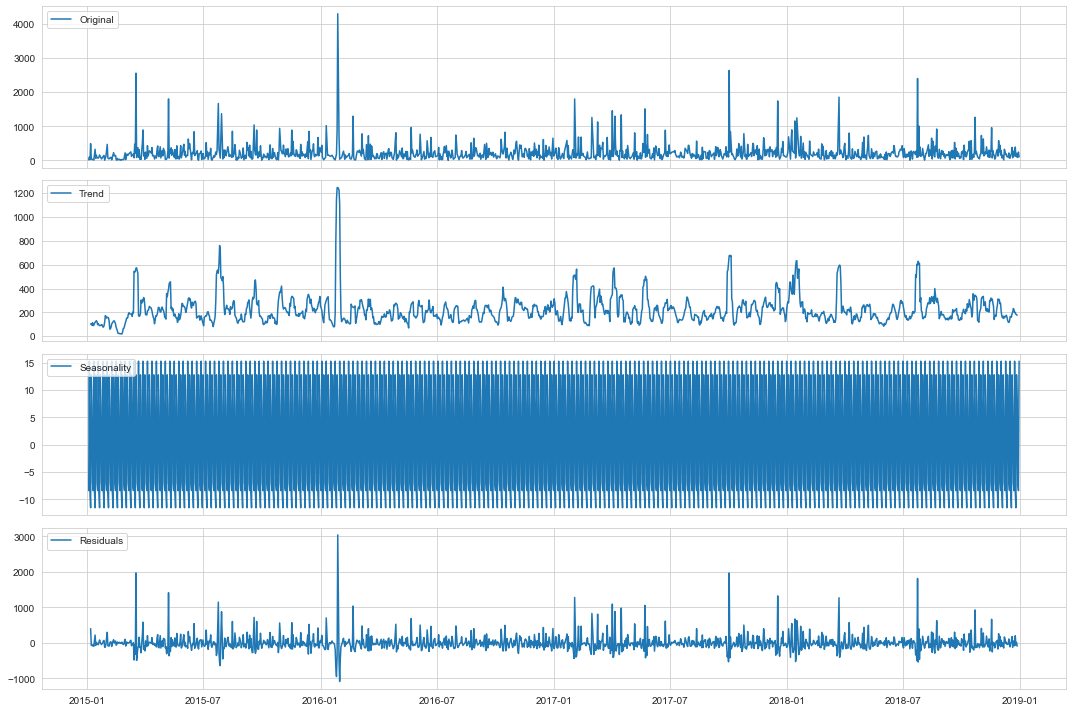

In [15]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(daily_sales["Sales"], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

plt.tight_layout()
plt.savefig(r"figures\decomposition_daily_sales.pdf")
plt.show()

Let's now fit a ARIMA model to forecast the daily sales values. <br>
The ARIMA model has some hyperparameters (p, d and q). Let's first try to find the optimal hyperparameters by performing a grid search and choosing the best hyperparameters. <br> <br>
Hyperparameters:
- p: number of AR terms
- d: number of times to difference the data
- q: number of MA terms

In [52]:
# Lets first create a training and a hold-out test set which can later be used for making predictions
num_samples = daily_sales.shape[0]
num_samples_test = 7
X_train = daily_sales["Sales"].iloc[:(num_samples - num_samples_test)]
X_test = daily_sales["Sales"].iloc[(num_samples - num_samples_test):]

print(f"Number of samples: {num_samples}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

assert num_samples == X_train.shape[0] + X_test.shape[0], "Invalid separation into training and test set!"

Number of samples: 1458
Number of training samples: 1451
Number of test samples: 7


I decided to use the AIC value as criterion for finding the optimal hyperparameters. Let's now execute the grid search and use the best parameters for the final ARIMA model. Afterwards, let's make some plots and predictions on the hold-out test set.

In [53]:
from statsmodels.tsa.arima.model import ARIMA

p_list = np.arange(1, 5)
q_list = np.arange(1, 5)
d_list = np.arange(0, 2) # to incooperate linear trend and exponential trend 
best_aic = 1e8
best_params = (0, 0, 0)

for d in d_list:
    for q in q_list:
        for p in p_list:
            model = ARIMA(X_train, order=(p, d, q))
            results = model.fit()
            aic_val = results.aic
            if aic_val < best_aic:
                best_params = (p, d, q)
                best_aic = aic_val
                print(f"New best AIC of {aic_val} with params ({p}, {d}, {q})")

New best AIC of 20288.189282362582 with params (1, 0, 1)
New best AIC of 20285.85761410809 with params (2, 0, 1)
New best AIC of 20284.444332813557 with params (1, 0, 2)
New best AIC of 20281.9302301961 with params (1, 1, 1)
New best AIC of 20280.83041866584 with params (2, 1, 1)
New best AIC of 20277.75598745337 with params (3, 1, 1)


In [54]:
model = ARIMA(X_train, order=best_params)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2073      0.011     19.202      0.000       0.186       0.228
ar.L2          0.0576      0.025      2.270      0.023       0.008       0.107
ar.L3         -0.0591      0.032     -1.847      0.065      -0.122       0.004
ma.L1         -1.0000      2.697     -0.371      0.711      -6.287       4.287
sigma2      6.854e+04   1.85e+05      0.371      0.710   -2.93e+05     4.3e+05


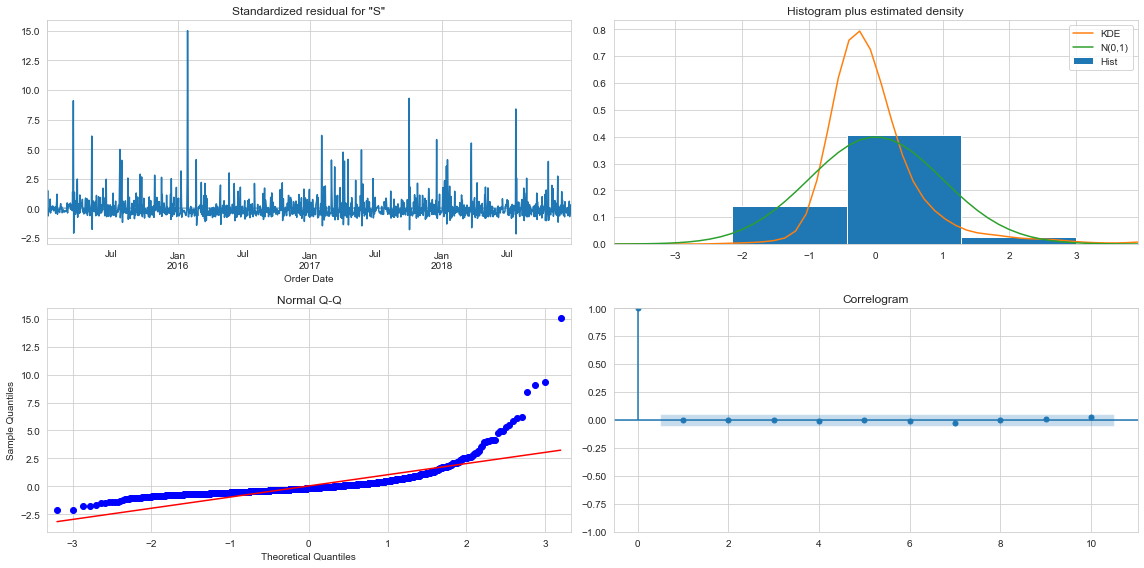

In [55]:
results.plot_diagnostics(figsize=(16, 8))
plt.tight_layout()
plt.savefig(r"figures\results_ARIMA.pdf")
plt.show()

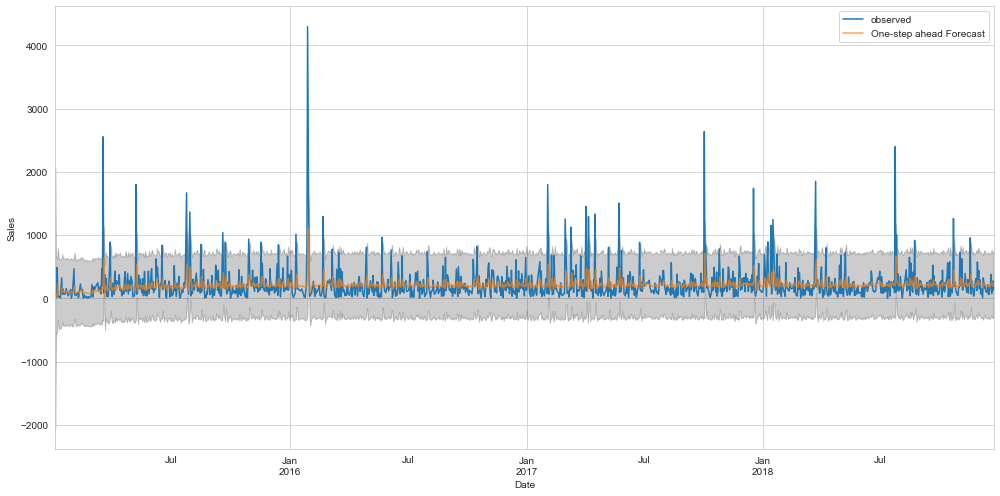

In [56]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-03'), dynamic=False) # variable to display plot for predicted values
pred_val = pred.conf_int()
ax = X_train['2014':].plot(label='observed') # displays plot for original values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7)) # displays plot for predicted values
ax.fill_between(pred_val.index,
                pred_val.iloc[:, 0],
                pred_val.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.savefig(r"figures\forecasting_ARIMA.pdf")
plt.show()

In [57]:
y_forecasted = pred.predicted_mean
y_truth = X_train.values

from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_forecasted, y_truth)
rmse = sqrt(mse)
print(f'The Root Mean Squared Error of the forecasts is {round(rmse, 2)}') 

The Root Mean Squared Error of the forecasts is 262.18


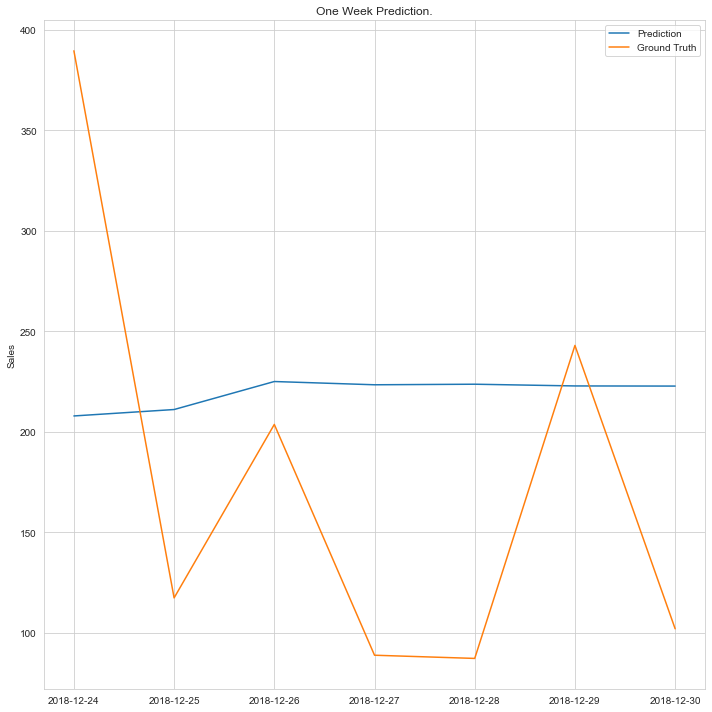

In [117]:
# Lets now make a forecast of num_samples_test samples
forecast = results.forecast(steps=7)

fig = plt.figure(figsize=(10, 10))
plt.plot(forecast.index, forecast.values, label="Prediction")
plt.plot(X_test.index, X_test.values, label="Ground Truth")
plt.title("One Week Prediction.")
plt.ylabel("Sales")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(r"figures\one_week_prediction_ARIMA.pdf")
plt.show()

In [67]:
mse = mean_squared_error(forecast, X_test.values)
rmse = sqrt(mse)
print(f'The Root Mean Squared Error of the one-week forecast is {round(rmse, 2)}') 

The Root Mean Squared Error of the one-week forecast is 115.86


## Train LSTM model
Let's now try to train a LSTM model, because this one seems more appropriate for long sequences and if someone wants to make a forecast longer into the future. Let's then compare the performance to the ARIMA model.

In [87]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

In [165]:
# Lets first create a training and a hold-out test set which can later be used for making predictions
num_samples = daily_sales.shape[0]
num_samples_test = 27
X_train = daily_sales["Sales"].iloc[:(num_samples - num_samples_test)]
X_test = daily_sales["Sales"].iloc[(num_samples - num_samples_test):]

print(f"Number of samples: {num_samples}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

assert num_samples == X_train.shape[0] + X_test.shape[0], "Invalid separation into training and test set!"

Number of samples: 1458
Number of training samples: 1431
Number of test samples: 27


In [191]:
# create training data, such that each training sample contains num_training_days samples 
# and the next sales value is the y_train value
num_training_days = 20

X_train_rnn, y_train_rnn = list(), list()
for i in range(0, X_train.shape[0]-num_training_days):
    X_train_rnn.append(X_train.iloc[i:i+num_training_days].values)
    y_train_rnn.append(X_train.iloc[i+num_training_days])

X_train_rnn = get_keras_format_series(X_train_rnn)
y_train_rnn = np.array(y_train_rnn)

X_test_init = X_test.iloc[:num_training_days].values
y_test = X_test.iloc[num_training_days:].values

In [192]:
print('Training input shape: {}'.format(X_train_rnn.shape))
print('Training output shape: {}'.format(y_train_rnn.shape))
print('Test input shape: {}'.format(X_test_init.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (1411, 20, 1)
Training output shape: (1411,)
Test input shape: (20,)
Test output shape: (7,)


In [176]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    Args:
        train_X (array): input sequence samples for training 
        train_y (list): next step in sequence targets
        cell_units (int): number of hidden units for RNN cells  
        epochs (int): number of training epochs   
    """

    # initialize model
    model = keras.models.Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(keras.layers.SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(keras.layers.Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-2))
    hist = model.fit(train_X, train_y, epochs=epochs, batch_size=64, validation_split=0.2, verbose=0)
    
    return model, hist

In [194]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(test_X_init, test_y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    test_X_init (array): initial sequence, must match model's input shape
    test_y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(test_y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_X_init.shape[0] + test_y.shape[0])
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    #plt.legend(['Initial Series','Target Series','Predictions'])

In [178]:
model_rnn, hist = fit_SimpleRNN(X_train_rnn, y_train_rnn, cell_units=30, epochs=200)

In [179]:
model_rnn.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 30)                960       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


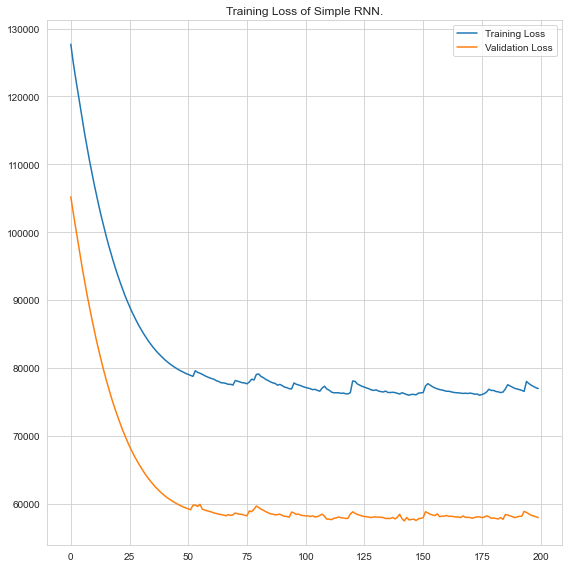

In [180]:
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.title("Training Loss of Simple RNN.")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(r"figures\training_loss_simple_RNN.pdf")
plt.show()

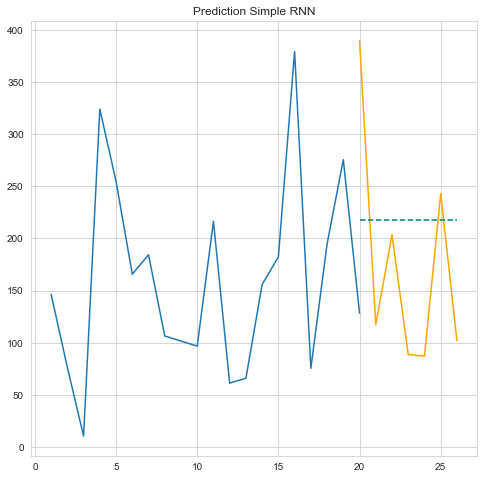

In [196]:
predict_and_plot(X_test_init, y_test, model_rnn, "Prediction Simple RNN")

In [182]:
def fit_SimpleLSTM(train_X, train_y, cell_units, epochs):
    """
    Fit Simple LSTM to data train_X, train_y 
    
    Args:
        train_X (array): input sequence samples for training 
        train_y (list): next step in sequence targets
        cell_units (int): number of hidden units for RNN cells  
        epochs (int): number of training epochs   
    """

    # initialize model
    model = keras.models.Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(keras.layers.LSTM(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(keras.layers.Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-2))
    hist = model.fit(train_X, train_y, epochs=epochs, batch_size=64, validation_split=0.2, verbose=0)
    
    return model, hist

In [183]:
model_lstm, hist = fit_SimpleLSTM(X_train_rnn, y_train_rnn, cell_units=70, epochs=200)

In [184]:
model_lstm.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


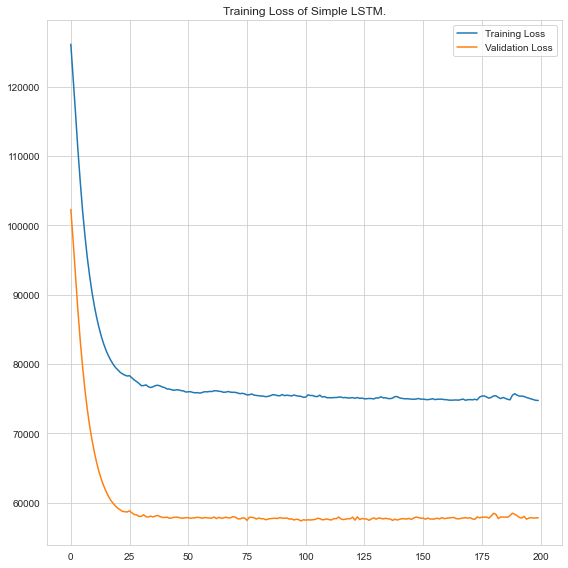

In [185]:
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.title("Training Loss of Simple LSTM.")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(r"figures\training_loss_simple_LSTM.pdf")
plt.show()

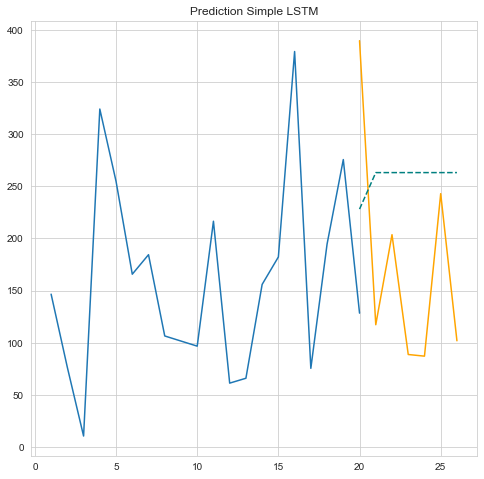

In [197]:
predict_and_plot(X_test_init, y_test, model_lstm, "Prediction Simple LSTM")